# Solving Problems with Spark DataFrame

## Intialization

In [1]:
import os
import sys


# Note that the path to spark home could be different for you. This one is for HortonWorks Data Platform
os.environ["SPARK_HOME"] = "/usr/hdp/current/spark2-client"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
# In below two lines, use /usr/bin/python2.7 if you want to use Python 2
os.environ["PYSPARK_PYTHON"] = "/usr/local/anaconda/bin/python"
os.environ["PYSPARK_DRIVER_PYTHON"] = "/usr/local/anaconda/bin/python"

# The version for py4j could be different for you
sys.path.insert(0, os.environ["PYLIB"] +"/py4j-0.10.4-src.zip")
sys.path.insert(0, os.environ["PYLIB"] +"/pyspark.zip")

# NOTE: Whichever package you want mention here.
# os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.10:0.4.1 pyspark-shell' 
# os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.6.0 pyspark-shell'
# com.databricks:spark-avro_2.11:3.2.0
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.6.0,com.databricks:spark-avro_2.11:3.2.0 pyspark-shell'

In [2]:
#Entrypoint 2.x
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Spark SQL basic example").enableHiveSupport().getOrCreate()

# On yarn:
# spark = SparkSession.builder.appName("Spark SQL basic example").enableHiveSupport().master("yarn").getOrCreate()
# specify .master("yarn")

sc = spark.sparkContext

In [3]:
from pyspark.sql import Row

## Problem Set: Analyse the crimes in Chicago

In [4]:
# Load data
df = spark.read.csv("/data/Chicago_Crimes-2001-to-present.csv._COPYING_", header=True)
df.show()

+-------+-----------+--------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|     ID|Case Number|                Date|               Block|IUCR|        Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+-------+-----------+--------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|2739513|   HJ372338|05/19/2003 01:15:...|     0000X E 74TH ST|0560|             ASSAULT|              SIMPLE|RESIDENCE PORCH/H

In [5]:
df.createOrReplaceTempView("chicago")
def q(query): spark.sql(query).show()

### Q1: Which top3 crime is most frequent?

In [13]:
q("select `Primary Type`, count(*) totals from chicago group by `Primary Type` order by totals desc limit 3")

+---------------+-------+
|   Primary Type| totals|
+---------------+-------+
|          THEFT|1293890|
|        BATTERY|1136963|
|CRIMINAL DAMAGE| 716668|
+---------------+-------+



### Q2: Which top 3 blocks are most dangerous

In [10]:
q("select Block, count(*) totals from chicago group by Block order by totals desc limit 3")

+------------------+------+
|             Block|totals|
+------------------+------+
|  100XX W OHARE ST| 14677|
|  001XX N STATE ST| 10420|
|076XX S CICERO AVE|  8759|
+------------------+------+



### Q3: Has the crime increased over the years?

In [14]:
yearwisedf = spark.sql("select year, count(*) totals from chicago group by year order by totals desc")

In [16]:
localdf = yearwisedf.toPandas()

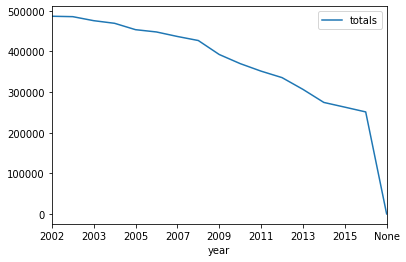

In [20]:
plt = localdf.plot(x="year")

## Q: Analyse the New York Stock Exchange

In [5]:
# Check Data
!hadoop fs -tail /data/NYSE_daily_File

-28	18.22	18.34	17.53	17.83	1739300	17.83
NYSE	CVA	2009-01-27	18.12	18.25	17.52	17.83	1360900	17.83
NYSE	CVA	2009-01-26	18.49	18.84	17.95	18.12	1340900	18.12
NYSE	CVA	2009-01-23	18.29	18.55	17.87	18.36	1258500	18.36
NYSE	CVA	2009-01-22	18.88	18.90	18.29	18.54	1623300	18.54
NYSE	CVA	2009-01-21	19.49	19.83	18.75	19.22	1598400	19.22
NYSE	CVA	2009-01-20	20.92	21.04	19.31	19.48	1435400	19.48
NYSE	CVA	2009-01-16	20.76	21.06	20.19	20.93	966600	20.93
NYSE	CVA	2009-01-15	19.40	20.75	19.30	20.43	1063900	20.43
NYSE	CVA	2009-01-14	19.69	19.95	19.00	19.64	1744100	19.64
NYSE	CVA	2009-01-13	20.11	20.11	19.31	19.65	1261200	19.65
NYSE	CVA	2009-01-12	20.46	20.88	19.91	20.24	700800	20.24
NYSE	CVA	2009-01-09	21.08	21.63	20.30	20.75	723800	20.75
NYSE	CVA	2009-01-08	21.08	21.25	20.43	20.81	1633700	20.81
NYSE	CVA	2009-01-07	22.34	22.50	21.22	21.32	1169500	21.32
NYSE	CVA	2009-01-06	22.85	22.92	22.25	22.50	1058700	22.50
NYSE	CVA	2009-01-05	21.79	22.89	21.49	22.68	981100	22.68
NYSE	CVA	2009-01-02	21.76	22.80	21

** Column definitions **

    exchange1 STRING,
    symbol1 STRING,
    ymd STRING,
    price_open FLOAT,
    price_high FLOAT,
    price_low FLOAT,
    price_close FLOAT,
    volume INT,
    price_adj_close FLOAT

In [7]:
df1 = spark.read.csv("/data/NYSE_daily_File", sep="\t",header=False, inferSchema=True)
df1.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: timestamp (nullable = true)
 |-- _c3: double (nullable = true)
 |-- _c4: double (nullable = true)
 |-- _c5: double (nullable = true)
 |-- _c6: double (nullable = true)
 |-- _c7: integer (nullable = true)
 |-- _c8: double (nullable = true)



In [21]:
# Using RDD
linesrdd = sc.textFile("/data/NYSE_daily_File")
from pyspark.sql import Row
def toRow(line):
    arr = line.split()
    return Row(exchange=arr[0], symbol1=arr[1], ymd=arr[2], price_open=float(arr[3]))

rowrdd = linesrdd.map(toRow)
nysedf = rowrdd.toDF()
nysedf.show()


+--------+----------+-------+----------+
|exchange|price_open|symbol1|       ymd|
+--------+----------+-------+----------+
|    NYSE|     35.39|    CLI|2009-12-31|
|    NYSE|     35.22|    CLI|2009-12-30|
|    NYSE|     35.69|    CLI|2009-12-29|
|    NYSE|     35.67|    CLI|2009-12-28|
|    NYSE|     35.38|    CLI|2009-12-24|
|    NYSE|     35.13|    CLI|2009-12-23|
|    NYSE|     34.76|    CLI|2009-12-22|
|    NYSE|     34.65|    CLI|2009-12-21|
|    NYSE|     34.11|    CLI|2009-12-18|
|    NYSE|     34.18|    CLI|2009-12-17|
|    NYSE|     34.79|    CLI|2009-12-16|
|    NYSE|      34.6|    CLI|2009-12-15|
|    NYSE|     34.21|    CLI|2009-12-14|
|    NYSE|     33.55|    CLI|2009-12-11|
|    NYSE|     33.61|    CLI|2009-12-10|
|    NYSE|     33.25|    CLI|2009-12-09|
|    NYSE|     32.57|    CLI|2009-12-08|
|    NYSE|     33.63|    CLI|2009-12-07|
|    NYSE|     33.46|    CLI|2009-12-04|
|    NYSE|     32.55|    CLI|2009-12-03|
+--------+----------+-------+----------+
only showing top

### Q1: Find out the standard deviation of price_open of symbol CLI

In [31]:
nysedf.filter("symbol1 == 'CLI'").select("price_open").describe().show()

+-------+------------------+
|summary|        price_open|
+-------+------------------+
|  count|               255|
|   mean|26.554470588235276|
| stddev| 5.932044004968906|
|    min|             14.39|
|    max|             53.23|
+-------+------------------+



In [32]:
# Or using Pandas
nyselocal = nysedf.filter("symbol1 == 'CLI'").select("price_open").toPandas()
nyselocal.describe()

,price_open
count,255.000000
mean,26.554471
std,5.932044
min,14.390000
25%,22.030000
50%,25.560000
75%,31.900000
max,53.230000


In [30]:
nysedf.describe()

DataFrame[summary: string, exchange: string, price_open: string, symbol1: string, ymd: string]

### Q2: Find out the standard deviation of price_open of symbol CVA

## Find IMDB top 50

In [9]:
!hadoop fs -ls /data/ml-100k

Found 23 items
-rw-r--r--   3 hdfs hdfs       6401 2019-07-22 17:55 /data/ml-100k/README
-rw-r--r--   3 hdfs hdfs        716 2019-07-22 17:55 /data/ml-100k/allbut.pl
-rw-r--r--   3 hdfs hdfs        643 2019-07-22 17:55 /data/ml-100k/mku.sh
-rw-r--r--   3 hdfs hdfs    1979173 2019-07-22 17:55 /data/ml-100k/u.data
-rw-r--r--   3 hdfs hdfs        202 2019-07-22 17:55 /data/ml-100k/u.genre
-rw-r--r--   3 hdfs hdfs         36 2019-07-22 17:55 /data/ml-100k/u.info
-rw-r--r--   3 hdfs hdfs     236344 2019-07-22 17:55 /data/ml-100k/u.item
-rw-r--r--   3 hdfs hdfs        193 2019-07-22 17:55 /data/ml-100k/u.occupation
-rw-r--r--   3 hdfs hdfs      22628 2019-07-22 17:55 /data/ml-100k/u.user
-rw-r--r--   3 hdfs hdfs    1586544 2019-07-22 17:55 /data/ml-100k/u1.base
-rw-r--r--   3 hdfs hdfs     392629 2019-07-22 17:55 /data/ml-100k/u1.test
-rw-r--r--   3 hdfs hdfs    1583948 2019-07-22 17:55 /data/ml-100k/u2.base
-rw-r--r--   3 hdfs hdfs     395225 2019-07-22 17:55 /data/ml-100k/u2.test
-rw-r--r-

In [10]:
u_item = spark.read.csv("/data/ml-100k/u.item", header=False, sep="|")
u_data = spark.read.csv("/data/ml-100k/u.data", header=False, sep="\t")
u_data.createOrReplaceTempView("u_data")
u_item.createOrReplaceTempView("u_item")
movie_ratings = spark.sql("select _c1 as movie_name, AVG(_c2) as avg_ratings, count(*) as counts from u_data group by _c1")
movie_ratings.createOrReplaceTempView("movie_ratings")    
top100movies = spark.sql("select * from movie_ratings where counts > 100 order by avg_ratings DESC limit 100")
top100movies.createOrReplaceTempView("top100movies")
top100movienames = spark.sql("select tm.*, ui._c1 from top100movies tm, u_item ui where ui._c0 = tm.movie_name")
top100movienames.show()


+----------+------------------+------+--------------------+
|movie_name|       avg_ratings|counts|                 _c1|
+----------+------------------+------+--------------------+
|       408| 4.491071428571429|   112|Close Shave, A (1...|
|       318| 4.466442953020135|   298|Schindler's List ...|
|       169| 4.466101694915254|   118|Wrong Trousers, T...|
|       483|  4.45679012345679|   243|   Casablanca (1942)|
|        64| 4.445229681978798|   283|Shawshank Redempt...|
|       603|4.3875598086124405|   209|  Rear Window (1954)|
|        12| 4.385767790262173|   267|Usual Suspects, T...|
|        50|4.3584905660377355|   583|    Star Wars (1977)|
|       178|             4.344|   125| 12 Angry Men (1957)|
|       134| 4.292929292929293|   198| Citizen Kane (1941)|
|       427| 4.292237442922374|   219|To Kill a Mocking...|
|       357| 4.291666666666667|   264|One Flew Over the...|
|        98|  4.28974358974359|   390|Silence of the La...|
|       480| 4.284916201117318|   179|No

## Amazon Reveiws

In [6]:
# Create dataframe from this file /data/amazon_review_full_csv/train.csv such that it has three columns: rating, title, review "rating", "title", "review"
# If the title or review contains a double quote, it is represented as "" (i.e. two double quotes) 

data = sc.textFile("/data/amazon_review_full_csv/train.csv")

In [7]:
def read_strings(lines):
    found = []
    current_string = ""
    in_string = False
    i = 0
    while i < len(lines):
        c = lines[i]
        if not in_string:
            if c == '"':
                in_string = True
            elif c in [' ', ','] :
                pass
            else:
                print("Something is wrong. Found ", c , ' between strings')
        elif c == '"':
            if i < (len(lines) - 1) and lines[i+1] == '"':
                current_string += '"'
                i += 1
            else:
                found.append(current_string)
                current_string = ""
                in_string = False
        else:
            current_string += c
        i += 1
    return found

def to_row(line):
    obj = read_strings(line)
    return Row(label=int(obj[0]), title=obj[1], review=obj[2])

rowrdd = data.map(to_row)


In [8]:
df = rowrdd.toDF()
df.show()


+-----+--------------------+--------------------+
|label|              review|               title|
+-----+--------------------+--------------------+
|    3|Gave this to my d...|  more like funchuck|
|    5|I hope a lot of p...|           Inspiring|
|    5|I'm reading a lot...|The best soundtra...|
|    4|The music of Yasu...|    Chrono Cross OST|
|    5|Probably the grea...| Too good to be true|
|    5|There's a reason ...|There's a reason ...|
|    1|This is a self-pu...|        Buyer beware|
|    4|I was a dissapoin...|Errors, but great...|
|    1|A complete waste ...|          The Worst!|
|    1|I guess you have ...|           Oh please|
|    1|I feel I have to ...|Awful beyond belief!|
|    4|When you hear fol...|A romantic zen ba...|
|    5|Excellent stockin...|Lower leg comfort...|
|    3|It took almost 3 ...|Delivery was very...|
|    2|sizes are much sm...|sizes recomended ...|
|    3|Full of intrigue ...|            Overbury|
|    1|Rather than scrat...|Another Abysmal D...|


### Q1: Find the top100 most frequent words in review column

In [9]:
import re
re.sub("[^a-zA-Z0-9]", "", "dkshfkshd7&&*")

'dkshfkshd7'

In [ ]:
def subesp(line):
    return re.sub("[^a-zA-Z0-9]", "", line).lower()

wordsrdd = rowrdd.flatMap(lambda row: row['review'].split()).map(subesp)
wordcounts = wordsrdd.map(lambda word: (word, 1)).reduceByKey(lambda x, y: x+y)
wordcounts.sortBy(lambda x: -x[1]).take(100)

## Twitter Data

In [14]:
# Data is located here: /data/SentimentFiles/SentimentFiles/upload/data/tweets_raw/

In [14]:
tweets = sc.textFile("/data/SentimentFiles/SentimentFiles/upload/data/tweets_raw/")
objs = tweets.take(2)
o1 = objs[0]
import json
obj = json.loads(o1)

from pprint import pprint
pprint(obj)



{'contributors': None,
 'coordinates': None,
 'created_at': 'Thu May 02 19:39:28 +0000 2013',
 'entities': {'hashtags': [],
              'symbols': [],
              'urls': [{'display_url': 'bit.ly/132JAYp',
                        'expanded_url': 'http://bit.ly/132JAYp',
                        'indices': [111, 133],
                        'url': 'http://t.co/9CwF31E8Ez'}],
              'user_mentions': []},
 'favorite_count': 0,
 'favorited': False,
 'filter_level': 'medium',
 'geo': None,
 'id': 330043883738234880,
 'id_str': '330043883738234880',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'lang': 'en',
 'place': None,
 'possibly_sensitive': False,
 'retweet_count': 0,
 'retweeted': False,
 'source': '<a href="http://twitterfeed.com" rel="nofollow">twitterfeed</a>',
 'text': "'Iron Man 3' Crushes Opening Day Records In China: \n"
         'Iron Man 3 has co

### Q1: Create a dataframe having: id, text, user_id

In [17]:
from pyspark.sql.types import Row
def toRow(line):
    obj = json.loads(line)
    return Row(id=obj['id'], text=obj['text'], user_id=obj['user']['id'])


rowtweet = tweets.map(toRow)
df = rowtweet.toDF()
df.show()


+------------------+--------------------+----------+
|                id|                text|   user_id|
+------------------+--------------------+----------+
|330043883738234880|'Iron Man 3' Crus...| 356267194|
|330043886577799169|Iron Man 3 tonigh...|1321576074|
|330043887055937536|Preciso ver Iron ...| 311092441|
|330043888788197376|'Iron Man 3' Crus...| 341314868|
|330043889589288960|Iron man 3 was aw...| 503242961|
|330043890440749057|RT @HannahMenzies...|  15800855|
|330043896786726913|RT @puthatasstowo...|1332324654|
|330043897516531714|Iron man 3 with t...|  77419974|
|330043897847877632|'Iron Man 3' Crus...| 632647072|
|330043899097784320|Al final de Iron ...|1149104400|
|330043900410601472|'Iron Man 3' Crus...| 307170579|
|330043901970874370|I realllllly want...| 475623023|
|330043902872657922|'Iron Man 3' Crus...| 229517060|
|330043907192811520|'Iron Man 3' Crus...| 273957922|
|330043907306053632|@mabtorr seccion ...|  22187314|
|330043907540926465|Can everyone just...| 4310

### Q2: Find the top100 most frequent words in text column